# Machine Learning Classification

In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score

In [70]:
dataset = pd.read_csv('Data after PP/Data')

In [71]:
dataset = dataset.drop(['Unnamed: 0'],axis=1)

In [72]:
dataset

,mu1,lam1,mu2,sigma,mu3,sigma3,w1,w2,w3,n_spikes,Target
0,0.099999,0.010000,1.376800e-01,0.069408,0.368091,0.172628,0.286221,4.179009e-01,2.958779e-01,1015.0,0.0
1,0.019293,0.019831,6.633874e-02,0.000100,0.100001,0.000520,1.000000,1.192093e-07,1.421085e-14,10364.0,0.0
2,0.043575,0.029764,1.779872e-01,0.000100,0.100064,0.000260,1.000000,1.192093e-07,1.421085e-14,4589.0,0.0
3,0.024164,0.022119,6.418069e-02,0.000100,0.100010,0.000718,1.000000,1.192093e-07,1.421085e-14,8274.0,0.0
4,0.048184,0.030814,4.696582e-03,0.000100,0.100139,0.000218,1.000000,1.192093e-07,1.421085e-14,4151.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
543,0.100000,0.011880,1.038845e-01,0.058294,0.483309,0.271518,0.332834,4.549999e-01,2.121657e-01,1029.0,1.0
544,0.018542,0.018771,1.807094e-01,0.000100,0.100000,0.000106,1.000000,1.192093e-07,1.421085e-14,10784.0,1.0
545,0.099969,0.039687,9.343772e-02,0.040354,0.267501,0.112234,0.630343,2.080073e-01,1.616492e-01,1523.0,1.0
546,0.056240,0.031443,1.643654e-07,0.000100,0.100001,0.000100,1.000000,1.192093e-07,1.421085e-14,3555.0,1.0


In [73]:
dataset['Target'].value_counts()

0.0    317
1.0    231
Name: Target, dtype: int64

## Train test split

In [74]:
X = dataset.drop(['Target'],axis=1)
y= dataset['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

## Standardization

In [75]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model Comparison

In [76]:
cv = StratifiedKFold(4)

## 1) Decision Tree Classifier

In [77]:
params = {'max_depth':np.linspace(2,10,dtype='int'),'criterion':['gini','entropy']}

clf = DecisionTreeClassifier(random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs=gs.fit(X_train,y_train)

In [78]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)



Best parameters set found : {'criterion': 'entropy', 'max_depth': 4} 

Classification report on Test set

Accuracy:  0.912
Recall:  0.931
Precision:  0.871
ROC AUC:  0.915


## 2) Logistic Regression

In [79]:
params = {'C':np.logspace(-3,3,50),'penalty':['l1','l2','elasticnet']}

clf = LogisticRegression(solver='liblinear',random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs=gs.fit(X_train,y_train)

In [80]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)



Best parameters set found : {'C': 0.21209508879201905, 'penalty': 'l1'} 

Classification report on Test set

Accuracy:  0.825
Recall:  0.655
Precision:  0.905
ROC AUC:  0.802


## 3) Support Vector Machines

In [81]:
params = {'C':np.logspace(-3,3,50),'kernel':['linear','rbf']}

clf = SVC(random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs=gs.fit(X_train,y_train)

In [82]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)



Best parameters set found : {'C': 8.286427728546842, 'kernel': 'rbf'} 

Classification report on Test set

Accuracy:  0.927
Recall:  0.931
Precision:  0.9
ROC AUC:  0.928


## 4) Random Forest

In [83]:
params = {'n_estimators':np.linspace(10,150,dtype='int',num=10),'max_depth':np.linspace(2,5,dtype='int'),'criterion':['gini','entropy']}

clf = RandomForestClassifier(n_jobs=-1,random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,verbose=10,n_jobs=-1)

gs=gs.fit(X_train,y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [ ]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)

## 5) Neural Net

In [85]:
X_train.shape

(411, 10)

In [86]:
import torch
print(torch.cuda.is_available())


False


In [131]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            20, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_50 (Dense)             (None, 100)               2100      
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 51        
Total params: 7,421
Trainable params: 7,421
Non-trainable params: 0
___________________________________________________

In [132]:
metrics = [
    'accuracy',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]


history=model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=200,
    callbacks=callbacks,
    validation_data=(X_test, y_test),

)

Epoch 1/200
42/42 [==============================] - 1s 25ms/step - loss: 0.5271 - accuracy: 0.7518 - fn: 48.0000 - fp: 54.0000 - tn: 184.0000 - tp: 125.0000 - precision: 0.6983 - recall: 0.7225 - val_loss: 0.4227 - val_accuracy: 0.7883 - val_fn: 28.0000 - val_fp: 1.0000 - val_tn: 78.0000 - val_tp: 30.0000 - val_precision: 0.9677 - val_recall: 0.5172
Epoch 2/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3774 - accuracy: 0.8345 - fn: 43.0000 - fp: 25.0000 - tn: 213.0000 - tp: 130.0000 - precision: 0.8387 - recall: 0.7514 - val_loss: 0.3456 - val_accuracy: 0.8613 - val_fn: 13.0000 - val_fp: 6.0000 - val_tn: 73.0000 - val_tp: 45.0000 - val_precision: 0.8824 - val_recall: 0.7759
Epoch 3/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3486 - accuracy: 0.8516 - fn: 32.0000 - fp: 29.0000 - tn: 209.0000 - tp: 141.0000 - precision: 0.8294 - recall: 0.8150 - val_loss: 0.2772 - val_accuracy: 0.9197 - val_fn: 5.0000 - val_fp: 6.0000 - val_tn: 73.0000 - val_t

dict_keys(['loss', 'accuracy', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])


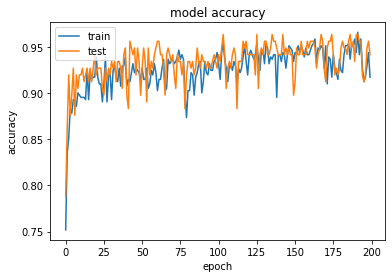

In [135]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [136]:
y_true, y_pred = y_test, model.predict_classes(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)

Accuracy:  0.942
Recall:  0.948
Precision:  0.917
ROC AUC:  0.942
